This notebook aims to analyze the aquaplanet TC nondevelopers and developers and their interactions with convectively coupled kelvin waves (CCKWs). Developers/non-developers were found from a precompiled list from Rosimar Rios-Berrios, and CCKW data in hovmoller form was also provided by a script from Rosi that I made some slight mods to (analysis_of_TCgen+CCEWs_mpas_aqua_sstmax10N_SUNNYEDITS.ipynb). 

Rosimar-Rios Berrios (2024) identified 33 "special" developers that formed 1.5-3.5 days after passage of a CCKW at the genesis longitude, where genesis is more favored.

We will also take a look at developers that do not form in this special window. 
See paper her paper here for more info: https://www.atmos.albany.edu/facstaff/tang/papers/2024_TCGenesisKelvinWaves_MWR.pdf

The output of this script is a csv of track timeseries data for equatorial EW developers and non-developers that are identified as intersecting with a CCKW during its lifetime. 

File summary: 

Input files: 
---------------
basic_output_from_TRACK_25Jan2023_all_candidates.csv (timeseries of all dev/non-dev waves in aquaplanet simulation)

TCG_TC_3km_35N1tstepwarmcore_unstructuredmesh.csv (snapshot of properties for ALL developers (ID,lat,lon,etc) at time of official cyclogenesis) 

Kelvin_TCG_on_peak_TempestExtremes.csv ('snapshot of properties of the 33 special developers (ID,lat,lon,etc) that developed 1.5-3.5 days after CCKW crest interaction')

cckw_hovmoller_data.npz (CCKW hovmoller diagram with lon/day coordinates)

Output files: 
----------------
eq_ndv_updated -> updated timeseries of track information for equatorial (<20N) non-developing easterly waves that intersect with CCKW, add addtl info such as CCKW crest cross time etc 

eq_dv_updated -> updated timeseries of track information for the 33 special equatorial (<20N) developing easterly waves that intersect with CCKW, add addtl info such as CCKW crest cross time etc 

eq_dv_outside_window_updated -> updated timeseries of track information for the non-special equatorial (<20N) developing easterly waves that intersect with CCKW, add addtl info such as CCKW crest cross time etc 

** SUNNY: use lon/lat_TRACK or just lat/lon? Need to ping Rosi on this!

In [4]:
# Import relevant packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import random
import ipdb
from IPython.display import clear_output
from helper_functions_and_scripts.my_utils import add_track_indices_and_cckw_intersection
import sys
from pathlib import Path


In [5]:
#Which simulation are we gonna pull data from? 

data_dir =  Path("/glade/u/home/sjsharma/CCKW_Project/data_and_scripts_from_3km_simulation")

#Which folder are we going to save the data in? 
save_dir = Path("/glade/u/home/sjsharma/CCKW_Project/CNN/CNN_outputs_3km")

In [4]:
# Load data from file Rosi sent me over email, all developing/nondeveloping wave candidates.
all_cases = pd.read_csv(f'{data_dir}/basic_output_from_TRACK_all_candidates')

# This dataset starts on March 30 00:00:00, so create & adjust day column to match the kelvin wave data which starts 12 hrs prior
all_cases["day_adj"] = (all_cases["fhr"] + 12) / 24

#Let's convert the valid_time column to a datetime object
all_cases['valid_time'] = pd.to_datetime(all_cases['valid_time'],format="%Y-%m-%d %H:%M:%S")

In [5]:
all_cases

,ID,fhr,valid_time,lon_TRACK,lat_TRACK,vor850,day_adj
0,3,0.0,2000-03-30 00:00:00,20.692614,10.108530,2.678050,0.50
1,3,6.0,2000-03-30 06:00:00,18.166260,8.450158,2.724016,0.75
2,3,12.0,2000-03-30 12:00:00,16.616816,8.213354,3.013561,1.00
3,3,18.0,2000-03-30 18:00:00,15.962998,8.618612,3.511255,1.25
4,3,24.0,2000-03-31 00:00:00,15.330037,8.744750,3.896803,1.50
...,...,...,...,...,...,...,...
24970,6706,3102.0,2000-08-06 06:00:00,278.704163,26.471022,1.195978,129.75
24971,6706,3108.0,2000-08-06 12:00:00,280.316345,25.830238,1.155432,130.00
24972,6706,3114.0,2000-08-06 18:00:00,281.142914,24.706772,1.214352,130.25
24973,6706,3120.0,2000-08-07 00:00:00,281.602112,23.984079,1.204661,130.50


In [6]:
# Total number of cases over simulation (both developers and nondevelopers)
all_IDs_cnt = all_cases["ID"].nunique()
print(all_IDs_cnt)

#As seen below, we have 1012 nondeveloping waves total, and 200 developing waves total. 

1212


In [7]:
# Load in tropical cyclogenesis data (at all latitudes) - 200 of them 
tcg_cases = pd.read_csv(f"{data_dir}/TCG_TC_3km_35N1tstepwarmcore_unstructuredmesh.csv")
tcg_cases['valid_time'] = pd.to_datetime(tcg_cases['valid_time'],format="%Y-%m-%d_%H.%M.%S") #get genesis time for that storm ID 

#How many happen equatorward of 20N? 
tcg_ID_cnt_equatorward = tcg_cases['ID'][tcg_cases['lat_TRACK']<20].nunique()

all_eq_tcg = tcg_cases['ID'][tcg_cases['lat_TRACK']<20]


In [8]:
# Remove the developers from the total list
tcg_IDs = tcg_cases["ID"].unique()
all_IDs = all_cases["ID"].unique()

# Find the unique values not common to both lists using set symmetric difference
unique_values = list(set(tcg_IDs) ^ set(all_IDs))

# Timeseries of all nondevelopers
all_ndv = all_cases[all_cases["ID"].isin(unique_values)]
all_ndv_cnt = all_ndv.nunique()

lat_lim = 20
eq_ndv_raw = all_ndv[all_ndv["lat_TRACK"] < lat_lim]

#How many nondevelopers equatorward of 20N do we have? (at least for part of their track). 
unique_eq_ndv = eq_ndv_raw.nunique()
unique_eq_ndv
# 576 non-developers that meet this criteria!

ID             576
fhr            536
valid_time     536
lon_TRACK     7750
lat_TRACK     7749
vor850        7732
day_adj        536
dtype: int64

In [8]:
# We are primarily interested in the subset of 33 developers <20N that form 1-3ish days after interaction w/ a CCKW.

# Now the question is: how many nondevelopers don't form after interacting with a CCKW?

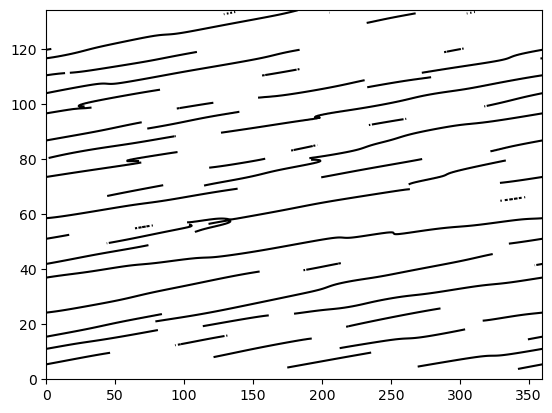

In [9]:
# Load in CCKW Hovmoller Data

data = np.load(f"{data_dir}/cckw_hovmoller_data.npz")
lon_meshgrid = data["X"] #lon
day_meshgrid = data["Y"] #day
waveData = data["waveData"]
waveDatadt_pos = data["waveDatadt_pos"]
cs = plt.contour(lon_meshgrid, day_meshgrid, waveDatadt_pos, levels=[0], colors="k")


In [10]:
# To be safe, create a copy of the equatorial nondeveloper dataset
eq_ndv = eq_ndv_raw.copy()

# Groupby the equatorial nondevelopers by ID.

eq_ndv_groupID = eq_ndv.groupby("ID")


In [11]:
# While we're at it, let's also create a groupby object for the equatorial developers by ID.

devData_raw = pd.read_csv(f"{data_dir}/Kelvin_TCG_on_peak_TempestExtremes.csv")
devData = devData_raw.copy()
devData["day_adj"] = (devData["fhr"] + 12) / 24  # Adjust the time to match CCKW


developer_IDs = devData["ID"].unique()  # Get all developer IDs for the 33 cases <20N
eq_dv = all_cases[
    all_cases["ID"].isin(developer_IDs)].copy()  # Extract the 33 cases from the overall dataset

#Let's tack on tc-genesis time to the 33 special developers. 

# Find exact locations of TC genesis
tcgen_day = np.zeros(len(devData))
tcgen_lon = np.zeros(len(devData))
tcgen_ID = np.zeros(len(devData))
idx_lon_raw = np.zeros(len(devData))
idx_day_raw = np.zeros(len(devData))

for i in range(0, len(devData)):
    tcgen_day[i] = devData.loc[i, "day_adj"]
    tcgen_lon[i] = devData.loc[i, "lon_TRACK"]
    tcgen_ID[i] = devData.loc[i, "ID"]

    # Find the index of the closest value
    idx_lon_raw[i] = np.unravel_index(np.abs(lon_meshgrid - tcgen_lon[i]).argmin(), lon_meshgrid.shape)[1]
    idx_day_raw[i] = np.unravel_index(np.abs(day_meshgrid - tcgen_day[i]).argmin(), lon_meshgrid.shape)[0]

#Create new column associated with tropical cyclogenesis 
eq_dv['tc_genesis'] = 0

eq_dv.loc[(eq_dv['ID'].isin(tcgen_ID)) &
       (eq_dv['lon_TRACK'].isin(tcgen_lon)) &
       (eq_dv['day_adj'].isin(tcgen_day)), 'tc_genesis'] = 1

eq_dv_groupID = eq_dv.groupby("ID")  # Group the 33 equatorial developers by ID




In [12]:
# #Let's also create a new dataframe for equatorial <20N developers that do NOT undergo TC genesis in the special 1-3.5 day widow after a CCKW interaction. 
#They may still *interact* with a CCKW, but they do not form in the 1-3.5 day window after the interaction.

dev_IDs_not_in_cckw_window = list( set(tcg_IDs) ^ set(developer_IDs)) #full list of developers that do not form in the 1-3.5 day window after a CCKW interaction

eq_dv_no_cckw_raw= all_cases[all_cases["ID"].isin(dev_IDs_not_in_cckw_window)]

#Truncate list to include data points of storms equatorward of 20N 
eq_dv_no_cckw = eq_dv_no_cckw_raw[eq_dv_no_cckw_raw["lat_TRACK"] < 20].copy()
eq_dv_no_cckw['tc_genesis'] = np.zeros(len(eq_dv_no_cckw))  # Initialize a new column for TC genesis, set to zero

# How many storms do we have now? 
eq_dv_no_cckw_cnt = eq_dv_no_cckw['ID'].nunique()

# Create a final dataframe to work with
eq_dv_outside_window_raw = eq_dv_no_cckw.copy()  # Create a final dataframe to work with

#Let's only keep the storms that undergo tcgenesis <20N and mark the genesis point as 1 in the new column
eq_dv_no_cckw_groupID = eq_dv_no_cckw.groupby("ID")

eq_dv_no_cckw_groupID

for ID, group in eq_dv_no_cckw_groupID:
    
    all_times = group["valid_time"]
    tc_gen_time = tcg_cases[tcg_cases['ID']==ID]['valid_time']

    is_it_in = np.sum(np.isin(all_times,tc_gen_time))

    if tc_gen_time.size == 0:  # Check if tc_gen_time is empty
        continue 

    if tc_gen_time.values[0] in all_times.values:

        eq_dv_outside_window_raw.loc[(eq_dv_no_cckw['ID'] == ID) & (eq_dv_no_cckw['valid_time'] == tc_gen_time.values[0]), 'tc_genesis'] = 1

# Now we have a dataframe of equatorial developers that do not form in the 1-3.5 day window after a CCKW interaction, and a column indicating whether they undergo TC genesis or not.
# Let's get rid of the developers that do not have any genesis points in the dataframe, they probably developed >20N. 

tc_ids = eq_dv_outside_window_raw[eq_dv_outside_window_raw['tc_genesis'] == 1]['ID']

eq_dv_outside_window = eq_dv_outside_window_raw[eq_dv_outside_window_raw['ID'].isin(tc_ids.values)]

#Let's create a groupby object for this 
eq_dv_outside_window_groupID = eq_dv_outside_window.groupby("ID")

Now that we have groupby objects for our 2 different developer groups & nondeveloper candidates in the aquaplanet simulation, we now shift gears to analyzing their interactions with the CCKW crests

In [13]:
# NEW METHOD (AS OF 07/06/2025)
#Pull the Kelvin wave crest (the zero contour) from the imported CCKW Data. Then, find the corrresponding indices for simulation day and longitude for where those crests exist. 

cckw_crests = cs.allsegs[0]
zero_coords = [] 
found = False 
lon_vector = lon_meshgrid[1,:]
day_vector = day_meshgrid[:,1]
cckw_crest_mask = np.zeros(np.shape(lon_meshgrid))

for array in cckw_crests:
    for pair in array:
        
        lon_val = pair[0]
        day_val = pair[1]

        closest_index_lon = np.argmin(np.abs(lon_vector - lon_val))
        closest_index_day = np.argmin(np.abs(day_vector - day_val))


        cckw_crest_mask[closest_index_day,closest_index_lon] = 1



In [14]:
#Get track data for all nondevelopers, all data

eq_ndv_updated = add_track_indices_and_cckw_intersection(
    eq_ndv_groupID, waveDatadt_pos, lon_meshgrid, day_meshgrid,cckw_crest_mask
)


In [15]:
#Get track data for developers <20N outside of the 1.5-3.5 day window.
eq_dv_outside_window_updated = add_track_indices_and_cckw_intersection(
    eq_dv_outside_window_groupID, waveDatadt_pos, lon_meshgrid, day_meshgrid,cckw_crest_mask
)


In [16]:
#Do the same for developers in the 1.5-3.5 day window, also tack on data on when the storms undergo TCgenesis 


eq_dv_updated = add_track_indices_and_cckw_intersection(eq_dv_groupID, waveDatadt_pos, lon_meshgrid, day_meshgrid,cckw_crest_mask)



In [17]:
#Quick analysis

#How many unique equatorial (<20N) nondevelopers total? 
total_ndv_cnt = eq_ndv_updated['ID'].nunique()

#How many of these ndv's have CCKW intersections? 
ndv_cckw_cross = eq_ndv_updated[eq_ndv_updated["cckw_crest_cross"] == 1]["ID"].unique()
ndv_cckw_cross_cnt = eq_ndv_updated[eq_ndv_updated["cckw_crest_cross"] == 1]["ID"].nunique()

#How many of these ndv's that have CCKW intersections also do not have big temporal gaps b/w pts?"
suspect_points = eq_ndv_updated[eq_ndv_updated["suspect_point"] == 1]["ID"].unique()

clean_ndv_cckw_cross_IDs = np.setdiff1d(ndv_cckw_cross,suspect_points) #ID's of all the CCKW crossing nondevelopers with all non-suspect points

#How many *total* CCKW crossings over all clean ndv's (all ndv's have data points with no big gaps in time) - and some storms have multiple CCKW crossings 

clean_cckw_crest_crossings = eq_ndv_updated[eq_ndv_updated['ID'].isin(clean_ndv_cckw_cross_IDs)]['cckw_crest_cross'] 


print(f" non dev's with CCKW intersections without any suspect points: {len(clean_ndv_cckw_cross_IDs)}")
print(f" total CCKW intersections from all nondevelopers that have no suspect points: {sum(clean_cckw_crest_crossings)}")



#Developer analysis - let's first analyze the classic 1.5-3.5day case identified by Rosi (should be 33 developers) 
print(f" eq dev's in special 1.5-3.5 day window with CCKW intersections: {eq_dv_updated['ID'].nunique()}")


dv_cckw_cross = eq_dv_updated[eq_dv_updated["cckw_crest_cross"] == 1]["ID"].unique()
suspect_points = eq_dv_updated[eq_dv_updated["suspect_point"] == 1]["ID"].unique()
clean_dv_cckw_cross_IDs = np.setdiff1d(dv_cckw_cross,suspect_points) #ID's of all the CCKW crossing nondevelopers with all non-suspect points
print(f" eq dev's in special 1.5-3.5 day window with CCKW intersections that have no suspect points : {len(clean_dv_cckw_cross_IDs)}")

#What about CCKW-intersecting developers that don't form in the special window above? 

dv_outside_cckw_cross = eq_dv_outside_window_updated[eq_dv_outside_window_updated["cckw_crest_cross"] == 1]["ID"].unique()
suspect_points = eq_dv_outside_window_updated[eq_dv_outside_window_updated["suspect_point"] == 1]["ID"].unique()
clean_dv_outside_cckw_cross_IDs = np.setdiff1d(dv_outside_cckw_cross,suspect_points) #ID's of all the CCKW crossing nondevelopers with all non-suspect points
print(f" eq dev's outside 1.5-3.5 day window with CCKW intersections: {eq_dv_outside_window_updated['ID'].nunique()}")
print(f" eq dev's outside 1.5-3.5 day window with CCKW intersections that have no suspect points : {len(clean_dv_outside_cckw_cross_IDs)}")


 non dev's with CCKW intersections without any suspect points: 231
 total CCKW intersections from all nondevelopers that have no suspect points: 269.0
 eq dev's in special 1.5-3.5 day window with CCKW intersections: 33
 eq dev's in special 1.5-3.5 day window with CCKW intersections that have no suspect points : 32
 eq dev's outside 1.5-3.5 day window with CCKW intersections: 77
 eq dev's outside 1.5-3.5 day window with CCKW intersections that have no suspect points : 53


In [18]:
#Let's save off the time series data for the nondevelopers and developers! 
eq_ndv_updated.to_csv(f"{save_dir}/01_outputs/eq_ndv_updated.csv", index=False)
eq_dv_updated.to_csv(f"{save_dir}/01_outputs/eq_dv_updated.csv", index=False)
eq_dv_outside_window_updated.to_csv(f"{save_dir}/01_outputs/eq_dv_outside_window_updated.csv", index=False) 